<a href="https://colab.research.google.com/github/Rogerio-mack/VLF/blob/main/VLF_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot routines

Automatically detects the formats of AWESOME (`.mat`) and SAVNET (`.fits`) files to generate graphs according to the formats.

> **AWESOME**,
>> Narrowband, Amplitude

>> Narrowband, Phase

>> Broadband, Spectogram

> **SAVNET**,
>> *, Amplitude + Phase



# Dependencies

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio
import scipy.signal as sg
import numpy as np
import pandas as pd
import datetime as dt
import os
from matplotlib.pyplot import * # rcparms
from matplotlib.dates import DateFormatter
from astropy.io import fits

In [2]:
path = '/content' # cache

# Routines

## `plot_pipe(data,fname,save=True,replace=False,cache_dir=None)`

In [3]:
def plot_pipe(data,fname,save=True,replace=False,cache_dir=None):
#
# if gráfico no cache: plot
# else: plot + save no cache
#
# return fig, rc
#
  if not replace and plot_is_cached(fname,cache_dir=cache_dir):
    img = plot_cached(fname,cache_dir=cache_dir)
    print('Warning: plot cached')
    return img, 0

  fig, rc = plot_vlf(data,fname)

  if rc == 0 and save:
      fig.savefig(cache_dir + fname.split('.')[0] + '.png', format='png')

  return fig, rc


## `plot_is_cached(fname,cache_dir=None)`

In [4]:
def plot_is_cached(fname,cache_dir=None):
#
# return True is plot is cached
#
  import os
  path_cache = cache_dir + '/'
  png_files = [ x for x in os.listdir(path_cache) if '.png' in x ]
  if fname.split('.')[0]+'.png' in png_files:
    return True
  else:
    return False

## `plot_cached(fname,cache_dir)`

In [5]:
def plot_cached(fname,cache_dir):
#
# plot a cached plot
#
# return img, 0
#
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  %matplotlib inline
  import os
  path_cache = cache_dir + '/'

  rcParams['figure.figsize'] = 7,4
  if len(fname) == 22: # é broadband, replace
    rcParams['figure.figsize'] = 7.5,4.5

  rcParams['figure.autolayout'] = True
  rcParams['font.size'] = 12

  img = mpimg.imread(path_cache + fname.split('.')[0] + '.png')

  plt.xticks([])
  plt.yticks([])
  imgplot = plt.imshow(img)
  plt.show()

  return img, 0


## `fix_phasedata180(data_phase, averaging_length)`

In [6]:
def fix_phasedata180(data_phase, averaging_length):
#
# return fix phase data 180 ONLY AWESOME data
#
  data_phase = np.reshape(data_phase,len(data_phase))
  x = np.exp(1j*data_phase*2./180.*np.pi)
  N = float(averaging_length)
  b, a = sg.butter(1, 0.021)
  y = sg.filtfilt(b, a, x)
  output_phase = data_phase - np.round( ((data_phase/180*np.pi-np.unwrap(np.angle(y))/2)%(2*np.pi))*180/np.pi/180 )*180
  temp = output_phase[0]%90
  output_phase = output_phase-output_phase[0]+temp
  s = output_phase[output_phase >= 180]
  for s in range(len(output_phase)):
      output_phase[s] = output_phase[s]-360
  return output_phase





## `fix_phasedata90(data_phase, averaging_length)`

In [7]:
def fix_phasedata90(data_phase, averaging_length):
#
# return fix phase data 90 ONLY AWESOME data
#
  data_phase = np.reshape(data_phase,len(data_phase))
  x = np.exp(1j*data_phase*4./180.*np.pi)
  N = float(averaging_length)
  b, a = sg.butter(1, 0.021)
  y = sg.filtfilt(b, a, x)
  output_phase = data_phase - np.round( ((data_phase/180*np.pi-np.unwrap(np.angle(y))/4)%(2*np.pi))*180/np.pi/90 )*90
  temp = output_phase[0]%90
  output_phase = output_phase-output_phase[0]+temp
  output_phase = output_phase%360
  s = output_phase[output_phase >= 180]
  for s in range(len(output_phase)):
      output_phase[s] = output_phase[s]-360
  return output_phase

## `plot_vlf(mat_contents0,fname)`

In [8]:
def plot_vlf(mat_contents0,fname):
#
# if fname is .mat: call plot_awesome()
# if fname is .fits: call plot_savnet() , NOT IMPLEMENTED YET
#
#  return fig, rc
#
  if fname.split('.')[1] == 'mat':
    fig, rc = plot_awesome(mat_contents0,fname)

  if fname.split('.')[1] == 'fits':
    fig, rc = plot_savnet(mat_contents0,fname)

  return fig, rc


## `plot_awesome(mat_contents0,fname)`

In [9]:
def plot_awesome(mat_contents0,fname):
#
# plot awesome data (.mat)
# depends on fname format,
#   plot narrowband data amplitude (file ends at 'A')
#   plot narrowband data phase (file ends at 'B')
#   plot broadband data spectogram
#
  rcParams['figure.figsize'] = 7,4
  rcParams['figure.autolayout'] = True
  rcParams['font.size'] = 12

#
# narrowband
#-----------------------------------------------------------------------------

  if len(fname) == 26: # é narrowband

    channel_sampling_freq0 = mat_contents0['Fs']
    data_amp               = mat_contents0['data']
    callsign0              = fname[14:17]
    adc_channel0           = mat_contents0['adc_channel_number']
    start_day0             = mat_contents0['start_day']
    start_hour0            = mat_contents0['start_hour']
    start_minute0          = mat_contents0['start_minute']
    start_month0           = mat_contents0['start_month']
    start_second0          = mat_contents0['start_second']
    start_year0            = mat_contents0['start_year']
    station_name0          = mat_contents0['station_name']

    startdate0             = dt.datetime(start_year0[0,0],start_month0[0,0],start_day0[0,0],start_hour0[0,0],start_minute0[0,0],start_second0[0,0])

    time0                  = pd.date_range(str(startdate0), periods=len(data_amp),
                                          freq=str(channel_sampling_freq0)[2:3]+' s')

    #'Type_ABCDF':       [21,21],
    # A is low resolution (1 Hz sampling rate) amplitude
    # B is low resolution (1 Hz sampling rate) phase
    # C is high resolution (50 Hz sampling rate) amplitude
    # D is high resolution (50 Hz sampling rate) phase
    # F is high resolution (50 Hz sampling rate) effective group delay

    plot_AB = fname[21]
    if (plot_AB != 'A') and (plot_AB != 'B'): # por hora só suporte A e B (low frequency)
      return_code = 500 # error
      return None, return_code

    if plot_AB == 'A': # amplitude
      df0 = pd.DataFrame(data_amp  , index=time0,columns=['amp'])

    if plot_AB == 'B': # phase

      # correct phase...
      #-------------------------------------------------------------------------
      AveragingLengthAmp = 1    # dados a cada 10seg
      AveragingLengthPhase = 1
      PhaseFixLength = 60
      averaging_length = channel_sampling_freq0*PhaseFixLength

      data_phase_fixed180 = fix_phasedata180(data_amp, averaging_length)
      data_phase_fixed190 = fix_phasedata90(data_phase_fixed180,averaging_length)

      offset = 0
      data_phase_unwrapped = np.zeros(len(data_phase_fixed190))
      data_phase_unwrapped[0] = data_phase_fixed190[0]

      for jj in range(1,len(data_phase_fixed190)):
          if data_phase_fixed190[jj]-data_phase_fixed190[jj-1] > 180:
              offset = offset + 360
          elif data_phase_fixed190[jj]-data_phase_fixed190[jj-1] < -180:
              offset = offset - 360
          data_phase_unwrapped[jj] = data_phase_fixed190[jj] - offset

      df0 = pd.DataFrame(data_phase_unwrapped, index=time0,columns=['phase'])

    df0_integrated = df0.resample('10 s').mean()    # dado de amplitude a cada 10 segundos

    try:
      fig, (ax0)=subplots(1)    #, sharex=True, sharey=False

      if plot_AB == 'A':
        ax0.plot(df0_integrated,'b:',lw=2,alpha=0.4,label='10s sampling')
        ax0.plot(df0_integrated.resample('60 s').mean(),alpha=0.8,color='black',lw=1,label='60s sampling')

      if plot_AB == 'B':
        ax0.plot(df0_integrated,color='darkblue',lw=1.5,alpha=0.9,label='10s sampling')

      ax0.set_xlabel('Time (UT Hours)')
      ax0.xaxis.set_major_formatter(DateFormatter('%H:%M'))
      ax0.grid(True)

      if plot_AB == 'A':
        ax0.set_ylim(0,np.nanmax( df0_integrated )*1.05)
        sub_title = 'Amplitude'
        ax0.set_ylabel('Averaged Amplitude [dB]')
      else:
        ax0.set_ylim(np.nanmin( df0_integrated )-100,np.nanmax( df0_integrated )+100)
        sub_title = 'Phase'
        ax0.set_ylabel('Averaged Phase [degrees]')

      if adc_channel0 == 0:
        ch = 'N/S'
      elif adc_channel0 == 1:
        ch = 'E/W'
      else:
        ch = ''

      ax0.set_title(''.join(map(lambda num: chr(num[0]),station_name0))+' '+ str(startdate0)[0:10]+' '+ str(callsign0) + ' ' + sub_title + ', ' + ch + ' Antenna', weight='bold')

      plt.legend(fontsize=8)

      plt.show()

      return_code = 0

    except:
      return_code = 550 # error

    return fig, return_code

#
# broadband
#-----------------------------------------------------------------------------

  if len(fname) == 22: # é broadband

    channel_sampling_freq0 = mat_contents0['Fs']
    data_amp               = mat_contents0['data']
    callsign0              = fname[14:17]
    adc_channel0           = mat_contents0['adc_channel_number']
    start_day0             = mat_contents0['start_day']
    start_hour0            = mat_contents0['start_hour']
    start_minute0          = mat_contents0['start_minute']
    start_month0           = mat_contents0['start_month']
    start_second0          = mat_contents0['start_second']
    start_year0            = mat_contents0['start_year']
    station_name0          = mat_contents0['station_name']

    startdate0             = dt.datetime(start_year0[0,0],start_month0[0,0],start_day0[0,0],start_hour0[0,0],start_minute0[0,0],start_second0[0,0])

    time0                  = pd.date_range(str(startdate0), periods=len(data_amp),
                                          freq=str(channel_sampling_freq0)[2:3]+' s')

    df0 = pd.DataFrame(data_amp  , index=time0,columns=['amp'])
#    df0_integrated = df0.resample('10 s').mean()    # dado de amplitude a cada 10 segundos

    try:
      rcParams['figure.figsize'] = 7.5,4.5
      fig, (ax0)=subplots(1)    #, sharex=True, sharey=False

      # Plot the spectrogram
      ax0.specgram(df0.amp, Fs=94000)

      pcm = ax0.pcolormesh(np.random.random((20, 20)), cmap='viridis')

      fig.colorbar(pcm,label='Intensity (dB)',ax=ax0)
      ax0.set_xlabel('Time (s)')
      ax0.set_ylabel('Frequency (Hz)')

      sub_title = 'Spectogram'
      ch = ''
      ax0.set_title(''.join(map(lambda num: chr(num[0]),station_name0))+' '+ str(startdate0)[0:10]+' '+ str(callsign0) + ' ' + sub_title + ', ' + ch + ' Antenna', weight='bold')

      plt.show()

      return_code = 0

    except:
      return_code = 550 # error

    return fig, return_code





## `plot_savnet(mat_contents0,fname)`

In [10]:
def plot_savnet(mat_contents0,fname):

  fx = mat_contents0
  header = []
  for a in fx[0].header.values():
    header.append(str(a))
  source = header[0:8]
  header = header[8::]

  fig, ax = plt.subplots(1,2,figsize=(16,5))

  try:
    rcParams['figure.figsize'] = 16,5
    rcParams['figure.autolayout'] = True
    rcParams['font.size'] = 10
    rcParams['xtick.labelsize'] = 10

    t = pd.date_range(fx[0].header['DATE-OBS'],periods=fx[0].header['NAXIS2'],freq='s')
    df = pd.DataFrame(fx[0].data.byteswap().newbyteorder() ,columns=header,index=t) # https://github.com/astropy/astropy/issues/1156

    df = df.resample('60 s').mean()

    for name in [x for x in header if 'Amp' in x]:
      ax[0].plot(df[name],label=name,lw=1,alpha=0.9)

    for name in [x for x in header if 'Phase' in x]:
      ax[1].plot(df[name],label=name,lw=1,alpha=0.9)

    ax[0].set_title(source[-1].upper() + ' - ' + source[-2] + ' - Amplitude',weight='bold',fontsize=16)
    ax[1].set_title(source[-1].upper() + ' - ' + source[-2] + ' - Phase',weight='bold',fontsize=16)
    ax[0].set_xlabel(header[0] + ' [sample 60s]',fontsize=12)
    ax[1].set_xlabel(header[0] + ' [sample 60s]',fontsize=12)
    ax[0].set_ylabel('Averaged Amplitude [dB]',fontsize=12)
    ax[1].set_ylabel('Averaged Phase [degrees]',fontsize=12)

    ax[0].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    ax[1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    ax[0].legend(loc='best',fontsize=9)
    ax[1].legend(loc='best',fontsize=9)
    ax[0].grid()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

    rc = 0

  except:
    rc = 255 # error

  return fig, rc

# Testes


## AWESOME graphs

In [11]:
!wget https://github.com/Rogerio-mack/VLF/raw/main/teste_data/B1070710000500NAA_006A.mat
!wget https://github.com/Rogerio-mack/VLF/raw/main/teste_data/B1070710000500NAA_006B.mat
!wget https://github.com/Rogerio-mack/VLF/raw/main/teste_data/B1070731210500_000.mat

'B1070710000500NAA_006A.mat', 'B1070710000500NAA_006B.mat', 'B1070731210500_000.mat'

--2023-10-21 14:56:09--  https://github.com/Rogerio-mack/VLF/raw/main/teste_data/B1070710000500NAA_006A.mat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Rogerio-mack/VLF/main/teste_data/B1070710000500NAA_006A.mat [following]
--2023-10-21 14:56:09--  https://raw.githubusercontent.com/Rogerio-mack/VLF/main/teste_data/B1070710000500NAA_006A.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352236 (344K) [application/octet-stream]
Saving to: ‘B1070710000500NAA_006A.mat’

B1070710000500NAA_0 100%[===================>] 343.98K  --.-KB/s    in 0.05s   

2023-10-21 14:56:09 (6.83 MB/s) - ‘B10707100

('B1070710000500NAA_006A.mat',
 'B1070710000500NAA_006B.mat',
 'B1070731210500_000.mat')

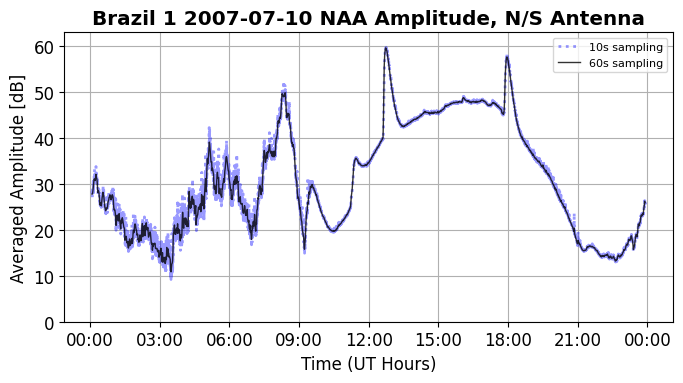

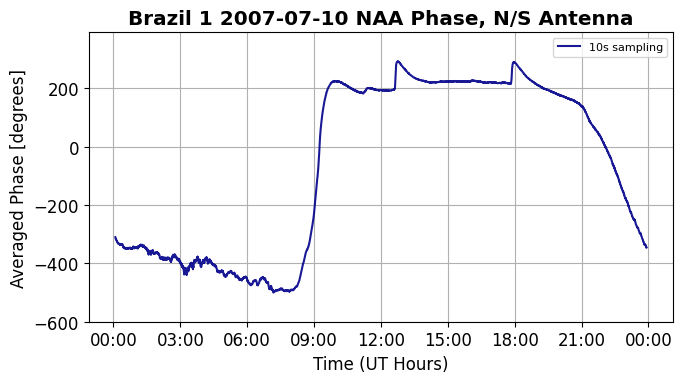

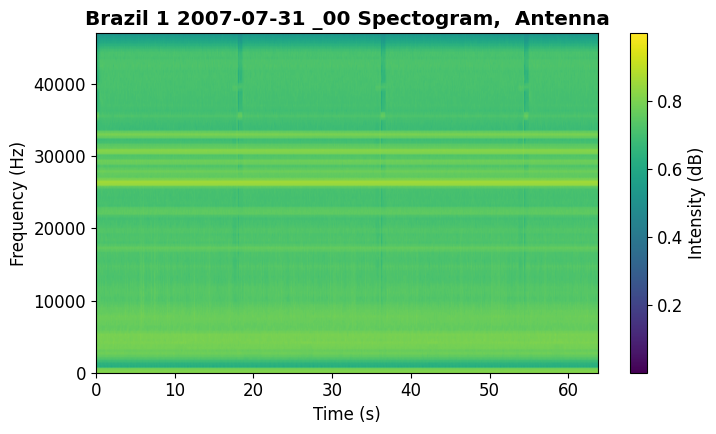

In [12]:
files = ['B1070710000500NAA_006A.mat', 'B1070710000500NAA_006B.mat', 'B1070731210500_000.mat']

for f in files:
  data = sio.loadmat(os.path.join(path,f))
  fig, rc = plot_vlf(data,f)


## AWESOME graphs cached

Execute first time to create cached graphs. Execute again to get graphs from cache.

In [13]:
!mkdir plot_cache

In [14]:
!ls /content/plot_cache/

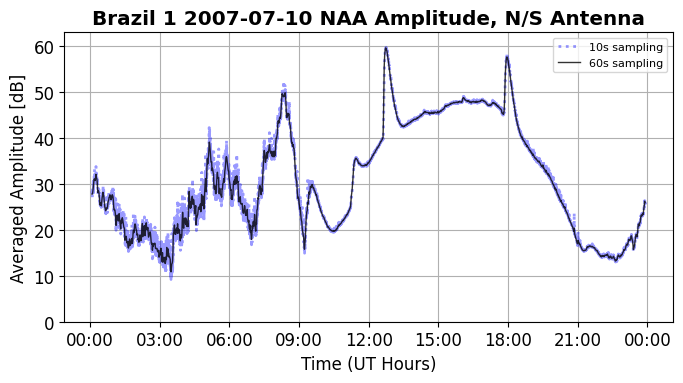

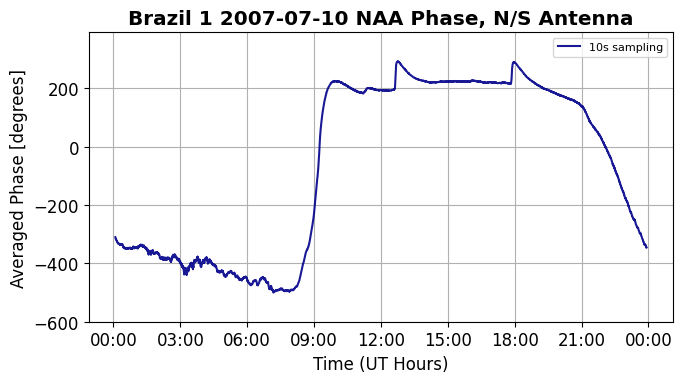

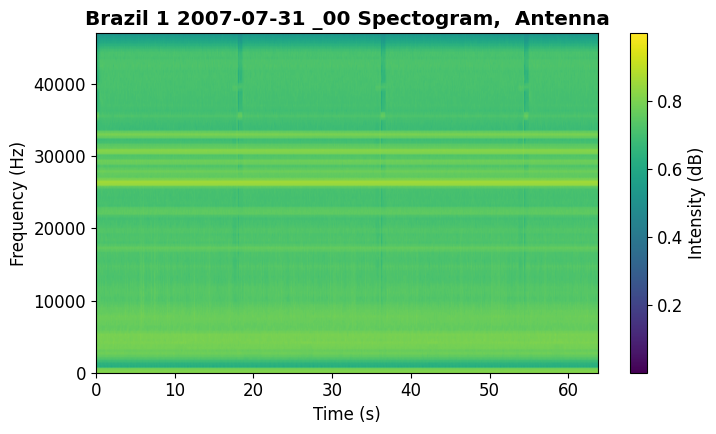

In [15]:
cache_dir = '/content/plot_cache/'

files = ['B1070710000500NAA_006A.mat', 'B1070710000500NAA_006B.mat', 'B1070731210500_000.mat']

for f in files:
  data = sio.loadmat(os.path.join(path,f))
  fig, rc = plot_pipe(data,f,cache_dir=cache_dir)

## SAVNET graphs

In [16]:
!wget https://github.com/Rogerio-mack/VLF/raw/main/teste_data/PIU-20110117.fits

--2023-10-21 14:56:23--  https://github.com/Rogerio-mack/VLF/raw/main/teste_data/PIU-20110117.fits
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Rogerio-mack/VLF/main/teste_data/PIU-20110117.fits [following]
--2023-10-21 14:56:23--  https://raw.githubusercontent.com/Rogerio-mack/VLF/main/teste_data/PIU-20110117.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5532480 (5.3M) [application/octet-stream]
Saving to: ‘PIU-20110117.fits’

PIU-20110117.fits   100%[===================>]   5.28M  --.-KB/s    in 0.1s    

2023-10-21 14:56:23 (50.6 MB/s) - ‘PIU-20110117.fits’ saved [5532480/5532480]



In [17]:
from astropy.io import fits
fname = 'PIU-20110117.fits'

fx = fits.open('/content/' + fname, memmap=True)
fx.info()

Filename: /content/PIU-20110117.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (16, 86400)   float32   


In [18]:
fx[0].header

SIMPLE  =                    T / Written by IDL:   4-Feb-2011 12:01:45.00       
BITPIX  =                  -32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                   16 /                                                
NAXIS2  =                86400 /                                                
DATE    = '04/02/11'           / Creation date (DD/MM/YY) of FITS header        
DATE-OBS= '2011-01-17'         /                                                
STATION = 'piura   '           /                                                
COL-1   = 'Time-UT (s)'        /                                                
COL-2   = 'GPS Delay (us)'     /                                                
COL-3   = 'NAA-V Phase (deg.)' /                                                
COL-4   = 'NAA-V Amp (dB)'     /                                                
COL-5   = 'NDK-V Phase (deg.

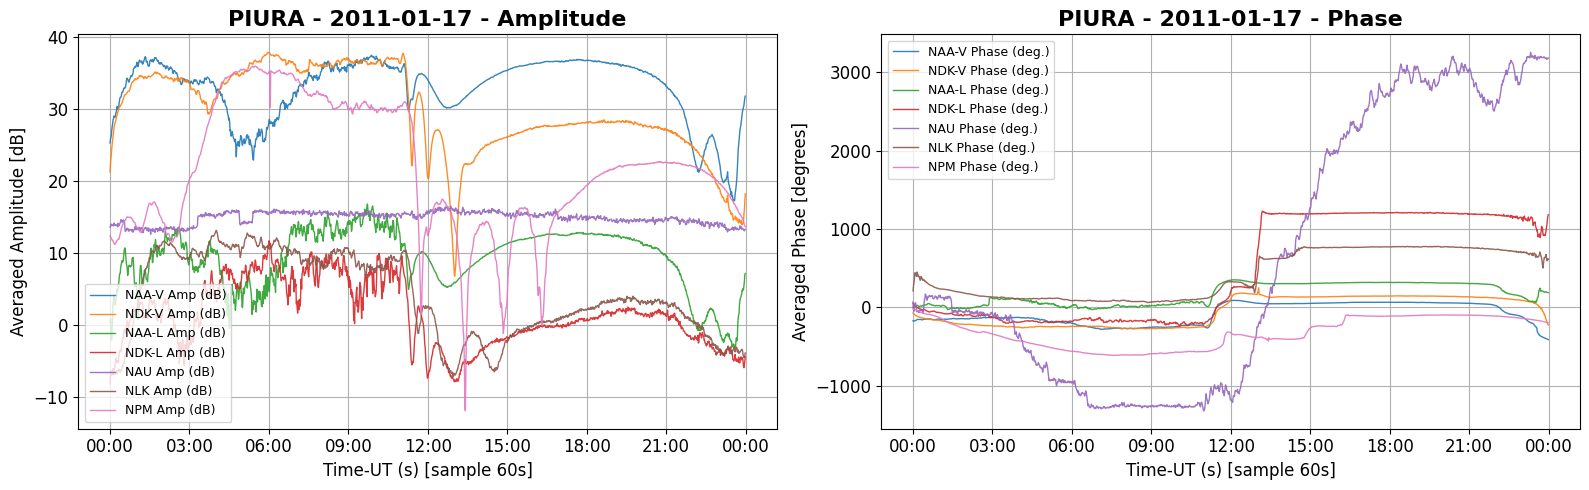

In [19]:
fig, rc = plot_vlf(fx,fname)

## SAVNET graphs cached

Execute first time to create cached graphs. Execute again to get graphs from cache.

In [20]:
!ls /content/plot_cache/

B1070710000500NAA_006A.png  B1070710000500NAA_006B.png	B1070731210500_000.png


In [21]:
!rm /content/plot_cache/*

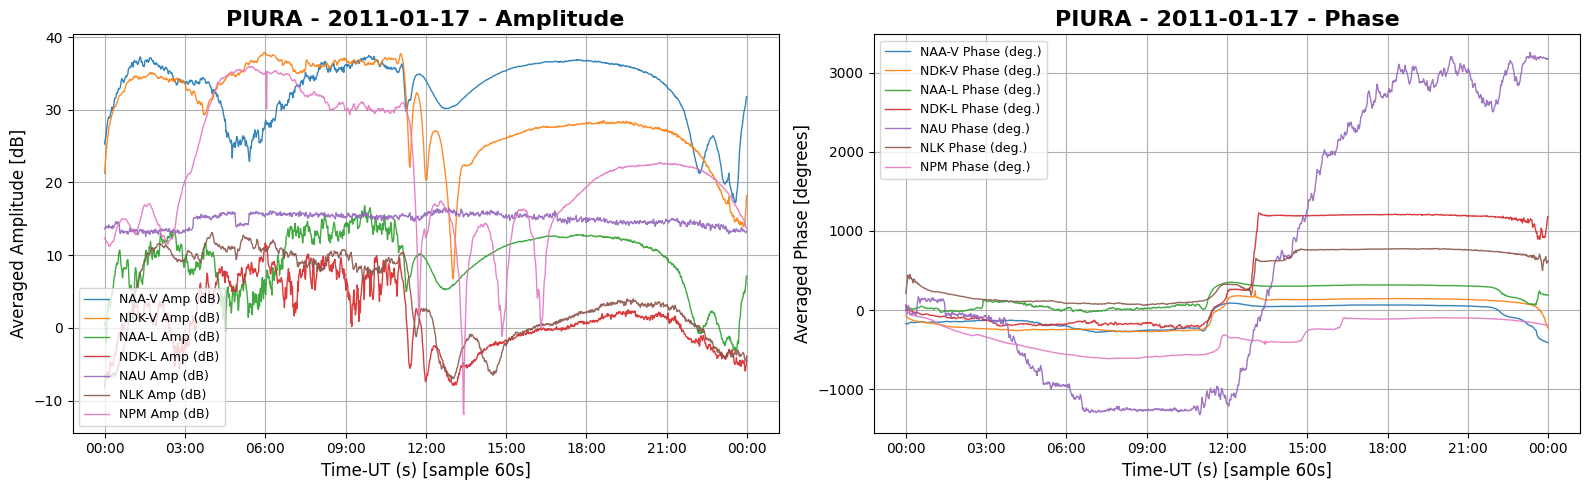

In [22]:
cache_dir = '/content/plot_cache/'

fig, rc = plot_pipe(fx,fname,cache_dir=cache_dir)